# COVID county analysis

This notebook tries to look at per-capita infection rates relative to county population. **This is not a very meaningful metric, because some counties are huge and some are tiny, but that doesn't necessarily correlate with density.**

We use the [New York Times country-level data](https://github.com/nytimes/covid-19-data). First, we download the latest data if we haven't done so recently.

In [96]:
from os.path import isfile, getmtime
from datetime import datetime, timedelta
from urllib.request import urlretrieve

def is_up_to_date(path):
    """Return true if a file is present and less than 6 hours old."""
    if not isfile(data_path):
        return false
    modified = datetime.fromtimestamp(getmtime(data_path))
    return modified > datetime.now() - timedelta(hours=6) 

# Download latest NYT data.
data_url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
data_path = "us-counties.csv"
if is_up_to_date(data_path):
    print("NYT county data is up to date as of latest run")
else:
    print("Downloading current NYT county data")
    urlretrieve(data_url, data_path)


NYT county data is up to date as of latest run


## Data preparation

Next, we want to load the NYT data, and combine it with recent population data [from the census](https://www.census.gov/data/datasets/time-series/demo/popest/2010s-counties-total.html). To do that, we'll start by loading and cleaning the NYT data.

In [83]:
import pandas as pd

us_counties_data = pd.read_csv(data_path)
latest_date = sorted(list(us_counties_data['date']), reverse = True)[0]
print(f"Latest data: {latest_date}")

todays_data = us_counties_data[us_counties_data['date'] == latest_date]
todays_columns = ["state", "county", "date", "cases", "deaths"]
todays_data = todays_data[todays_columns].set_index(["state", "county", "date"])
todays_data

Latest data: 2020-04-26


cases  deaths
state   county     date                     
Alabama Autauga    2020-04-26     37       2
        Baldwin    2020-04-26    161       3
        Barbour    2020-04-26     33       0
        Bibb       2020-04-26     38       0
        Blount     2020-04-26     34       0
...                              ...     ...
Wyoming Sublette   2020-04-26      1       0
        Sweetwater 2020-04-26     10       0
        Teton      2020-04-26     64       1
        Uinta      2020-04-26      6       0
        Washakie   2020-04-26      4       0

[2820 rows x 2 columns]

Next we'll clean and load the census population data.

In [86]:
census_path = "co-est2019-alldata.csv"
census_columns = ["STNAME", "CTYNAME", "POPESTIMATE2019"]
census_data = pd.read_csv(census_path, encoding = "latin-1")
census_data = census_data[census_data["SUMLEV"] == 50][census_columns]
census_data = census_data.rename(columns={ "STNAME": "state", "CTYNAME": "county", "POPESTIMATE2019": "pop2019" })
census_data["county"] = census_data["county"].transform(lambda c: c.replace(" County", ""))
census_data = census_data.set_index(["state", "county"])
census_data

pop2019
state   county             
Alabama Autauga       55869
        Baldwin      223234
        Barbour       24686
        Bibb          22394
        Blount        57826
...                     ...
Wyoming Sweetwater    42343
        Teton         23464
        Uinta         20226
        Washakie       7805
        Weston         6927

[3142 rows x 1 columns]

Finally, we'll join the census data into our table.

In [122]:
data = todays_data.join(census_data).dropna()
data

cases  deaths   pop2019
state   county     date                               
Alabama Autauga    2020-04-26     37       2   55869.0
        Baldwin    2020-04-26    161       3  223234.0
        Barbour    2020-04-26     33       0   24686.0
        Bibb       2020-04-26     38       0   22394.0
        Blount     2020-04-26     34       0   57826.0
...                              ...     ...       ...
Wyoming Sublette   2020-04-26      1       0    9831.0
        Sweetwater 2020-04-26     10       0   42343.0
        Teton      2020-04-26     64       1   23464.0
        Uinta      2020-04-26      6       0   20226.0
        Washakie   2020-04-26      4       0    7805.0

[2730 rows x 3 columns]

## Analysis

Next, we want to calculate the cases and deaths per 10,000.

In [126]:
data['cases/10k'] = data['cases'] / data['pop2019'] * 10000
data['deaths/10k'] = data['deaths'] / data['pop2019'] * 10000
data = data.round({'cases/10k': 2, 'deaths/10k': 2})
data

cases  deaths   pop2019  cases/10k  deaths/10k
state   county     date                                                      
Alabama Autauga    2020-04-26     37       2   55869.0       6.62        0.36
        Baldwin    2020-04-26    161       3  223234.0       7.21        0.13
        Barbour    2020-04-26     33       0   24686.0      13.37        0.00
        Bibb       2020-04-26     38       0   22394.0      16.97        0.00
        Blount     2020-04-26     34       0   57826.0       5.88        0.00
...                              ...     ...       ...        ...         ...
Wyoming Sublette   2020-04-26      1       0    9831.0       1.02        0.00
        Sweetwater 2020-04-26     10       0   42343.0       2.36        0.00
        Teton      2020-04-26     64       1   23464.0      27.28        0.43
        Uinta      2020-04-26      6       0   20226.0       2.97        0.00
        Washakie   2020-04-26      4       0    7805.0       5.12        0.00

[2730 rows x 5 columns]

## Visualization

Finally, let's plot the infection rate against the population.

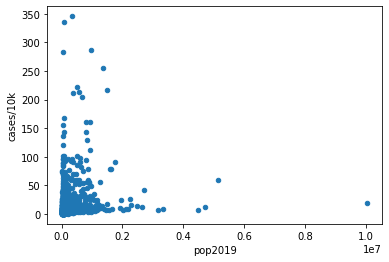

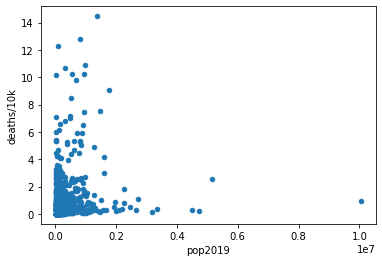

In [127]:
filtered = data[data['pop2019'] > 25000]
filtered.plot.scatter(y = 'cases/10k', x = 'pop2019')
filtered.plot.scatter(y = 'deaths/10k', x = 'pop2019')

In [128]:
data.sort_values('pop2019', ascending = False)

cases  deaths     pop2019  cases/10k  \
state        county      date                                               
California   Los Angeles 2020-04-26  19528     913  10039107.0      19.45   
Illinois     Cook        2020-04-26  30574    1313   5150233.0      59.36   
Texas        Harris      2020-04-26   5729      93   4713325.0      12.15   
Arizona      Maricopa    2020-04-26   3359     122   4485414.0       7.49   
California   San Diego   2020-04-26   3043     111   3338330.0       9.12   
...                                    ...     ...         ...        ...   
Colorado     Hinsdale    2020-04-26      3       0       820.0      36.59   
             Mineral     2020-04-26      2       0       769.0      26.01   
North Dakota Slope       2020-04-26      3       0       750.0      40.00   
Colorado     San Juan    2020-04-26      1       0       728.0      13.74   
New Mexico   Harding     2020-04-26      1       0       625.0      16.00   

                                     deaths/10k  
state        county      date                    
California   Los Angeles 2020-04-26        0.91  
Illinois     Cook        2020-04-26        2.55  
Texas        Harris      2020-04-26        0.20  
Arizona      Maricopa    2020-04-26        0.27  
California   San Diego   2020-04-26        0.33  
...                                         ...  
Colorado     Hinsdale    2020-04-26        0.00  
             Mineral     2020-04-26        0.00  
North Dakota Slope       2020-04-26        0.00  
Colorado     San Juan    2020-04-26        0.00  
New Mexico   Harding     2020-04-26        0.00  

[2730 rows x 5 columns]